In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [3]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [1]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
data_nan = pandas.read_csv('datasets/Tracks.csv', sep='\t')

In [5]:
data_nan.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut
0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,0.056365,...,1.058442,-211,0.911645,1,-1,0.114615,0.59521,0,0,0
1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,0.033095,...,3.121358,-211,0.796731,1,-1,0.051334,0.59521,0,0,0
2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,0.077636,...,10.585135,-211,0.946629,1,-1,1.856516,0.59521,0,0,0
3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,0.086603,...,7.485243,211,1.058989,1,1,0.577419,0.59521,0,0,0
4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,0.015694,...,5.617354,211,1.042135,1,1,1.314513,0.59521,0,0,0


In [6]:
event_id_column = 'event_id'
data_nan[event_id_column] = data_nan.run.apply(str) + '_' + data_nan.event.apply(str)

In [7]:
get_events_statistics(data_nan)

{'Events': 1005757, 'tracks': 27156193}

In [8]:
get_N_B_events()

742867.7142562866

## Remove NAN data

In [9]:
data = data_nan.dropna()
len(data_nan), len(data), get_events_statistics(data)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

## Add diff_pt and cos(diff_phi)

In [10]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    data['diff_pt'] = 0.
    max_pt = group_max(data[event_id_column].values.astype(str), data.partPt.values)
    data['diff_pt'] = max_pt - data['partPt'].values

# max is very similar
def group_max(groups, data):
    print len(groups), len(data)
    order = numpy.lexsort((data, groups))
    _, _groups = numpy.unique(groups, return_inverse=True)
    groups = groups[order] #this is only needed if groups is unsorted
    data = data[order]
    index = numpy.empty(len(groups), 'bool')
    index[-1] = True
    index[:-1] = groups[1:] != groups[:-1]
    return data[index][_groups]

In [11]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data['cos_diff_phi'] = numpy.cos(data.diff_phi.values)

27156190 27156190


/mnt/mfs/ipython_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


## Add max, sum among PIDs

In [12]:
from itertools import combinations
PIDs = numpy.array([data.PIDNNk.values, data.PIDNNe.values, data.PIDNNm.values])
PIDnames = numpy.array(['k', 'e', 'mu'])
for indices in combinations(range(len(PIDnames)), 2):
    data['max_PID_{}_{}'.format(*PIDnames[list(indices)])] = numpy.max(PIDs[list(indices)], axis=0)
    data['sum_PID_{}_{}'.format(*PIDnames[list(indices)])] = numpy.sum(PIDs[list(indices)], axis=0)

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [13]:
data['label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [14]:
data.columns

Index([u'run', u'event', u'Bmass', u'i', u'mult', u'partP', u'partPt', u'ptB', u'IPs', u'IP', u'IPerr', u'partlcs', u'EOverP', u'ghostProb', u'IPPU', u'nnkrec', u'PIDNNk', u'PIDNNpi', u'PIDNNp', u'PIDNNm', u'PIDNNe', u'diff_eta', u'diff_phi', u'phi', u'eta', u'proj', u'ID', u'veloch', u'signB', u'signTrack', u'Dist_phi', u'N_sig_sw', u'mu_cut', u'e_cut', u'K_cut', u'event_id', u'diff_pt', u'cos_diff_phi', u'max_PID_k_e', u'sum_PID_k_e', u'max_PID_k_mu', u'sum_PID_k_mu', u'max_PID_e_mu', u'sum_PID_e_mu', u'label'], dtype='object')

## Select protons and pions, ghost prob cut

In [15]:
threshold_mistag = 0.6
initial_cut = '(PIDNNp < {tr}) & (PIDNNpi < {tr}) & (ghostProb < 0.4)'.format(tr=threshold_mistag)
data = data.query(initial_cut)

## Select muons, kaons, electrons

In [16]:
threshold_kaon = 0.7 
threshold_muon = 0.4
threshold_electron = 0.6
cut_pid = """
            ((PIDNNk > {trk}) 
                | (PIDNNm > {trm}) 
                | (PIDNNe > {tre})) """.format(trk=threshold_kaon, trm=threshold_muon,
                                               tre=threshold_electron).replace("\n", "")
    
data = data.query(cut_pid)

In [17]:
get_events_statistics(data)

{'Events': 657874, 'tracks': 1191986}

## $\epsilon_{tag}$ calculation

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [18]:
N_B_passed = get_events_number(data)
tagging_efficiency = 1. * N_B_passed / get_N_B_events()
tagging_efficiency_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency, tagging_efficiency_delta

(0.66948228944480792, 0.00094932256580402023)

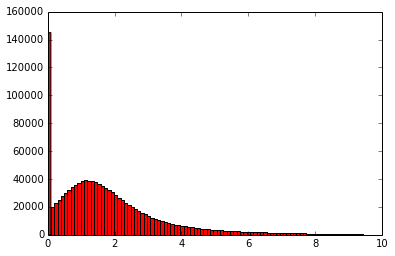

In [19]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

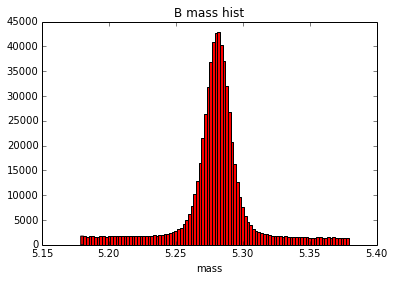

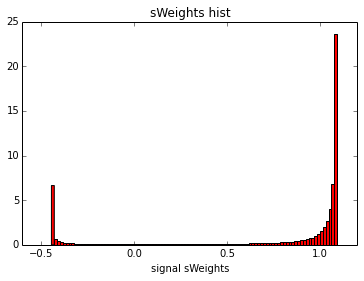

In [20]:
hist([gr['Bmass'].values[0] for _, gr in data.groupby(event_id_column)], bins=100)
title('B mass hist')
xlabel('mass')
show()
hist([gr['N_sig_sw'].values[0] for _, gr in data.groupby(event_id_column)], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
pass

### define B-like events for training and others for prediction

In [21]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 409381, 'tracks': 743076}

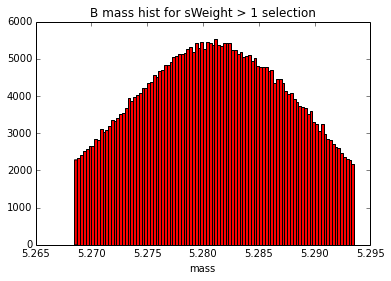

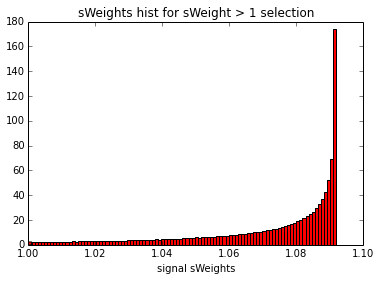

In [22]:
hist([gr['Bmass'].values[0] for _, gr in data_sw_passed.groupby(event_id_column)], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')
show()
hist([gr['N_sig_sw'].values[0] for _, gr in data_sw_passed.groupby(event_id_column)], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
pass

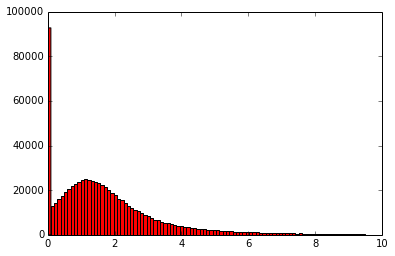

In [23]:
hist(data_sw_passed.diff_pt.values, bins=100)
pass

# Find good tracks to define sign B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [63]:
features = list(set(data.columns) - {'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label', 'thetaMin', 'Dist_phi', event_id_column, 
                                    'mu_cut', 'e_cut', 'K_cut'})
features

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'max_PID_e_mu',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'sum_PID_k_mu',
 'ptB',
 'sum_PID_e_mu',
 'sum_PID_k_e',
 'proj',
 'PIDNNe',
 'PIDNNk',
 'PIDNNm',
 'phi',
 'IP',
 'max_PID_k_mu',
 'IPerr',
 'IPs',
 'ID',
 'veloch',
 'max_PID_k_e',
 'diff_phi',
 'ghostProb',
 'IPPU',
 'eta',
 'partlcs']

## PID pairs scatters

/moosefs/ipython_env/local/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


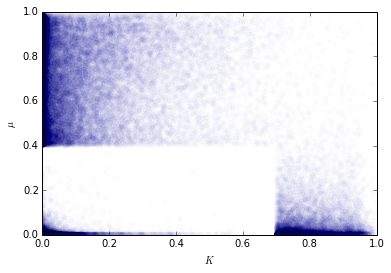

In [25]:
scatter(data_sw_passed['PIDNNk'].values, data_sw_passed['PIDNNm'].values, alpha=0.01)
xlabel('$K$')
ylabel('$\mu$')
ylim(0, 1)
xlim(0, 1)
pass

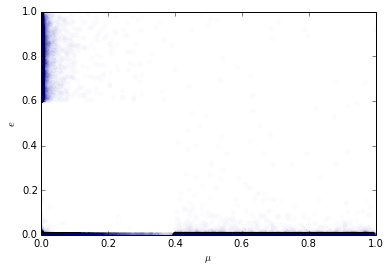

In [26]:
scatter(data_sw_passed['PIDNNm'].values, data_sw_passed['PIDNNe'].values, alpha=0.01)
xlabel('$\mu$')
ylabel('$e$')
ylim(0, 1)
xlim(0, 1)
pass

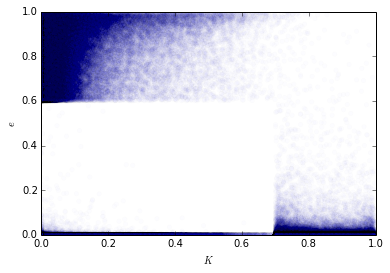

In [27]:
scatter(data_sw_passed['PIDNNk'].values, data_sw_passed['PIDNNe'].values, alpha=0.01)
xlabel('$K$')
ylabel('$e$')
ylim(0, 1)
xlim(0, 1)
pass

## pt

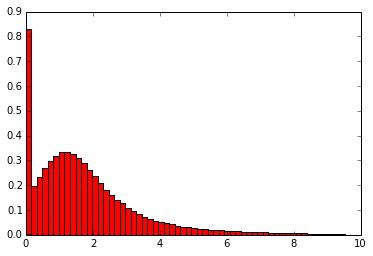

In [28]:
hist(data_sw_passed.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

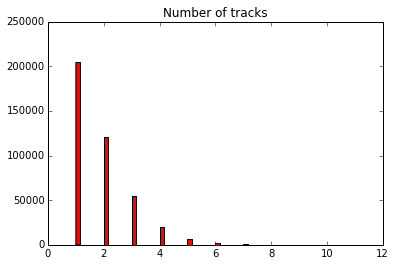

In [29]:
hist([len(gr) for num, gr in data_sw_passed.groupby(event_id_column)], bins=60)    
title('Number of tracks')
pass

## pids histograms

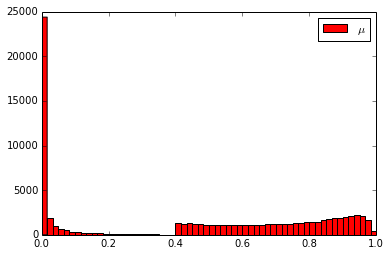

In [30]:
hist(data_sw_passed["PIDNNm"].values, bins=60, range=(0, 1), label='$\mu$')
legend()
pass

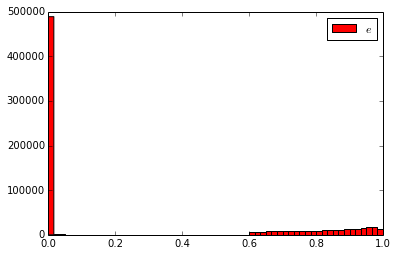

In [31]:
hist(data_sw_passed["PIDNNe"].values, bins=60, range=(0, 1), label='$e$')
legend()
pass

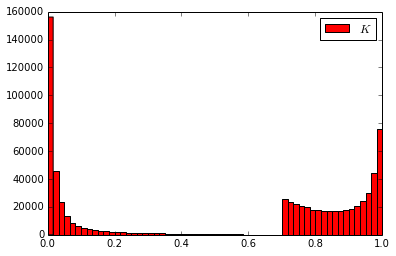

In [32]:
hist(data_sw_passed["PIDNNk"].values, bins=60, range=(0, 1), label='$K$')
legend()
pass

## 2-folding training selection tracks

In [64]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=100, n_jobs=8)
est_choose_RT = FoldingClassifier(base, features=features, random_state=11)
%time est_choose_RT.fit(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw)

CPU times: user 24min 37s, sys: 4.53 s, total: 24min 42s
Wall time: 24min 41s


FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         features=['cos_diff_phi', 'diff_pt', 'partPt', 'max_PID_e_mu', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'sum_PID_k_mu', 'ptB', 'sum_PID_e_mu', 'sum_PID_k_e', 'proj', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'phi', 'IP', 'max_PID_k_mu', 'IPerr', 'IPs', 'ID', 'veloch', 'max_PID_k_e', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

#### AUC

In [76]:
probs_RT = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
roc_auc_score(data_sw_passed.label.values, probs_RT, sample_weight=data_sw_passed.N_sig_sw.values)

KFold prediction using folds column


0.54755081030998232

#### ROC

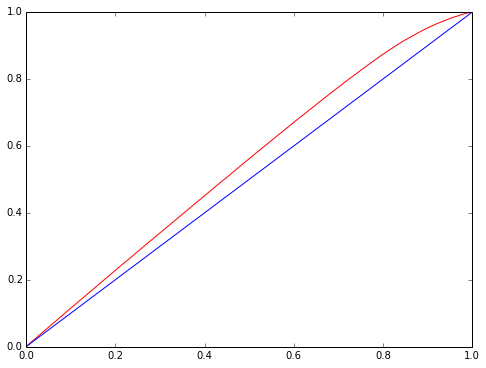

In [77]:
fpr, tpr, _ = roc_curve(data_sw_passed.label.values, probs_RT, sample_weight=data_sw_passed.N_sig_sw.values)
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [78]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(est_choose_RT.features)[numpy.argsort(-imp)]})

,feature,importance
0,IPs,1.000000
1,partPt,0.782027
2,IP,0.585122
3,IPerr,0.483644
4,diff_pt,0.475195
5,PIDNNm,0.407308
6,proj,0.374560
7,max_PID_k_e,0.286977
8,sum_PID_k_e,0.281498
9,IPPU,0.256665


#### Distributions for output

KFold prediction using folds column


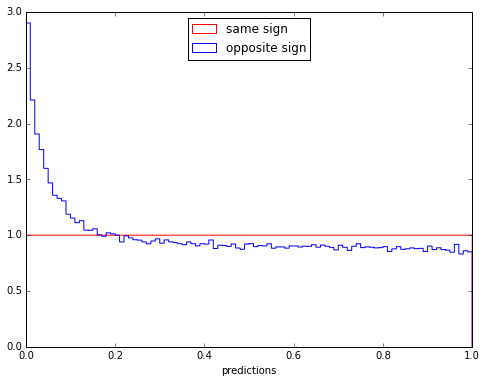

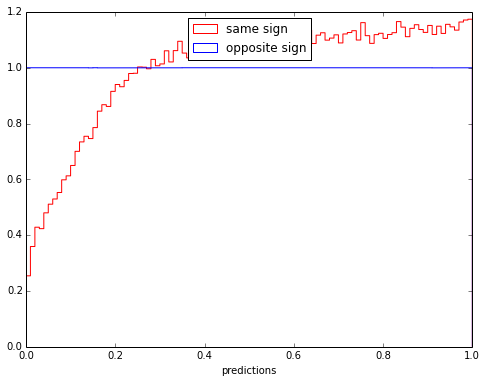

In [79]:
from utils import plot_flattened_probs
figsize(8, 6)
probs = est_choose_RT.predict_proba(data_sw_passed)
flat_ss = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=1)
flat_os = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=0)

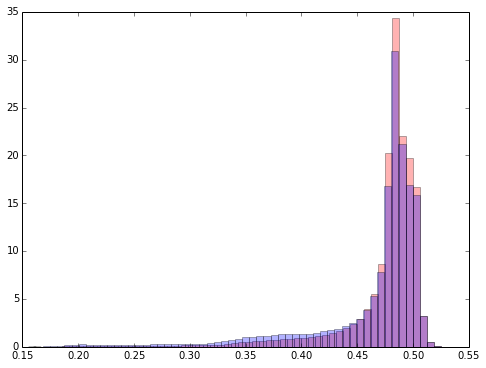

In [80]:
hist(probs[:, 1][data_sw_passed.label.values == 1], bins=60, alpha=0.3, normed=True)
hist(probs[:, 1][data_sw_passed.label.values == 0], bins=60, alpha=0.3, normed=True)
pass

#### Select top-good tracks in event

In [81]:
## select the better tracks by estimator in event (probability to be necessary sign)
def get_best_tracks(data, probs, count=1):
    train_prob = data.copy()
    train_prob.ix[train_prob.label == 1, 'prediction'] = probs[train_prob.label.values == 1]
    train_prob.ix[train_prob.label == 0, 'prediction'] = 1 - probs[train_prob.label.values == 0]
    
    add_tracks = []
    others = []
    for num, group in train_prob.groupby(event_id_column):    
        index = numpy.argsort(group['prediction'].values)[::-1]
        add_tracks.append(group.iloc[index[:count], :])
        others.append(group.iloc[index[count:], :])
    good_tracks = pandas.concat(add_tracks)
    other_tracks = pandas.concat(others)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

In [82]:
## select same sign and oposite sign tracks simultaneously
def get_pair_best_tracks(data, probs, count=1):
    train_prob = data.copy()
    train_prob.ix[train_prob['label'] == 1, 'prediction'] = probs[train_prob['label'].values == 1]
    train_prob.ix[train_prob['label'] == 0, 'prediction'] = 1 - probs[train_prob['label'].values == 0]
    
    add_tracks = []
    others = []
    for num, group in train_prob.groupby(event_id_column):    
        group_plus = group[group.label == 1]
        group_minus = group[group.label == 0]
    
        index = numpy.argsort(group_plus['prediction'].values)[::-1]
        add_tracks.append(group_plus.iloc[index[:count], :])
        others.append(group_plus.iloc[index[count:], :])
        index = numpy.argsort(group_minus['prediction'].values)[::-1]
        add_tracks.append(group_minus.iloc[index[:count], :])
        others.append(group_minus.iloc[index[count:], :])

    good_tracks = pandas.concat(add_tracks)
    other_tracks = pandas.concat(others)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

----

## Train to distinguish same sign vs opposite sign

In [42]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

### TT

In [87]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1500, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100))

In [88]:
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                               features=features)
%time tt_folding.fit(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw.values)

CPU times: user 24.5 s, sys: 1.85 s, total: 26.3 s
Wall time: 3min 34s


FoldingClassifier(base_estimator=DecisionTrainClassifier(bootstrap=True, depth=6, learning_rate=0.02,
            loss=LogLossFunction(regularization=100), max_features=15,
            n_estimators=1500, pretransform_needed=True),
         features=['cos_diff_phi', 'diff_pt', 'partPt', 'max_PID_e_mu', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'sum_PID_k_mu', 'ptB', 'sum_PID_e_mu', 'sum_PID_k_e', 'proj', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'phi', 'IP', 'max_PID_k_mu', 'IPerr', 'IPs', 'ID', 'veloch', 'max_PID_k_e', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile='ssh-ipy', n_folds=2, random_state=11)

In [89]:
probs_RT = tt_folding.predict_proba(data_sw_passed)[:, 1]
roc_auc_score(data_sw_passed.label.values, probs_RT, sample_weight=data_sw_passed.N_sig_sw.values)

KFold prediction using folds column


0.54857402832532554

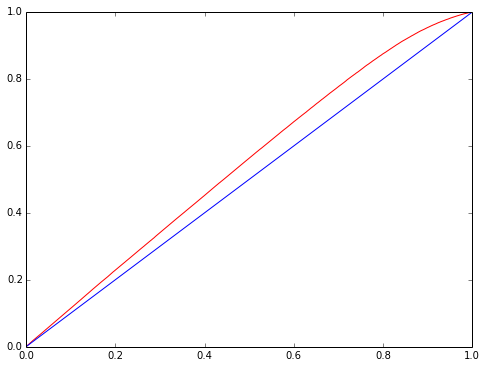

In [90]:
fpr, tpr, _ = roc_curve(data_sw_passed.label.values, probs_RT, sample_weight=data_sw_passed.N_sig_sw.values)
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [91]:
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
report = ClassificationReport({'tt': tt_folding}, 
                              LabeledDataStorage(data_sw_passed, data_sw_passed.label.values, 
                                                 data_sw_passed.N_sig_sw.values))

KFold prediction using folds column


In [92]:
from rep.report.metrics import RocAuc
lc = report.learning_curve(RocAuc())

Default prediction


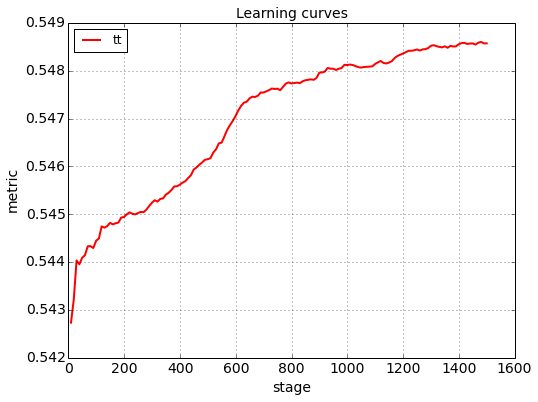

In [93]:
lc

### MN

In [ ]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares', 
                                     iterations=1000, regularization=0.02, sync=True)
mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11,
                               features=features)
%time mn_folding.fit(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw.values)

In [86]:
probs_RT = mn_folding.predict_proba(data_sw_passed)[:, 1]
roc_auc_score(data_sw_passed.label.values, probs_RT, sample_weight=data_sw_passed.N_sig_sw.values)

KFold prediction using folds column


0.54871855373057732

KFold prediction using folds column
Default prediction


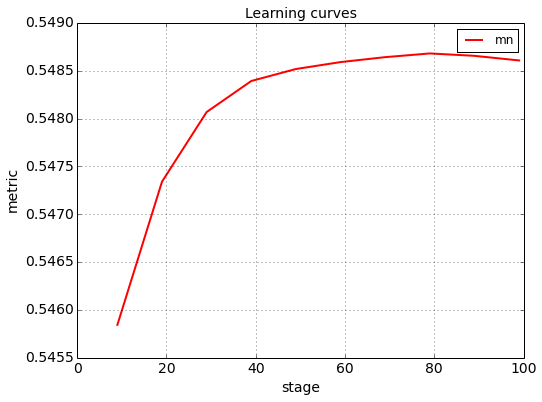

In [62]:
report = ClassificationReport({'mn': mn_folding}, 
                              LabeledDataStorage(data_sw_passed, data_sw_passed.label.values,
                                                 data_sw_passed.N_sig_sw.values))
report.learning_curve(RocAuc())

In [94]:
imp = numpy.sum([est.feature_importances_ for est in mn_folding.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(mn_folding.features)[numpy.argsort(-imp)]})

,feature,importance
0,IPs,1.000000
1,partPt,0.762106
2,proj,0.519259
3,IP,0.492765
4,diff_pt,0.380301
5,max_PID_e_mu,0.348335
6,veloch,0.288466
7,IPPU,0.258271
8,PIDNNm,0.229478
9,PIDNNk,0.196401


---------

### Forest selection

In [96]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
mask = ((flat_ss(temp_probs) < 0.2) & (data_sw_passed.label == 0)) | \
    ((flat_os(temp_probs) > 0.6) & (data_sw_passed.label == 1))
data_sw_passed_rf_selected = data_sw_passed[mask]
data_sw_passed_rf_not_selected = data_sw_passed[~mask]

KFold prediction using folds column


In [98]:
get_events_statistics(data_sw_passed_rf_selected)

{'Events': 210661, 'tracks': 266145}

In [99]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=5000, regularization=0.02, sync=False)
mn_folding_forest = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                      features=features)
mn_folding_forest.fit(data_sw_passed_rf_selected, data_sw_passed_rf_selected.label, 
                      data_sw_passed_rf_selected.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=5000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['cos_diff_phi', 'diff_pt', 'partPt', 'max_PID_e_mu', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'sum_PID_k_mu', 'ptB', 'sum_PID_e_mu', 'sum_PID_k_e', 'proj', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'phi', 'IP', 'max_PID_k_mu', 'IPerr', 'IPs', 'ID', 'veloch', 'max_PID_k_e', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

KFold prediction using folds column
Default prediction


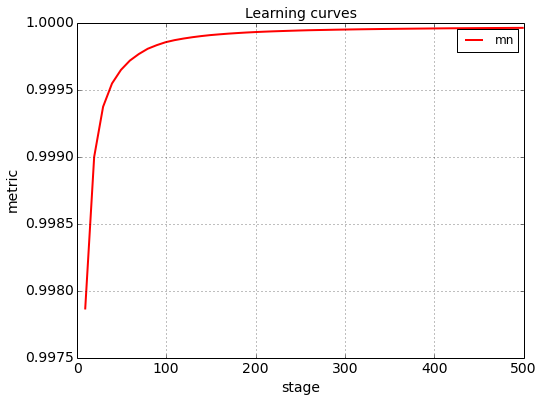

In [100]:
report = ClassificationReport({'mn': mn_folding_forest}, 
                              LabeledDataStorage(data_sw_passed_rf_selected, 
                                                 data_sw_passed_rf_selected.label.values,
                                                 data_sw_passed_rf_selected.N_sig_sw.values))
report.learning_curve(RocAuc())

----

### Top pair selection

In [102]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
data_sw_passed_pair_selected, data_sw_passed_pair_not_selected = get_pair_best_tracks(
    data_sw_passed, temp_probs, count=1)

KFold prediction using folds column
542837 200239


In [103]:
print get_events_statistics(data_sw_passed_pair_selected)
print get_events_statistics(data_sw_passed_pair_not_selected)

{'tracks': 542837, 'Events': 409381}
{'tracks': 200239, 'Events': 142507}


In [105]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=5000, regularization=0.02, sync=False)
mn_folding_forest_top = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                          features=features)
mn_folding_forest_top.fit(data_sw_passed_pair_selected, data_sw_passed_pair_selected.label, 
                          data_sw_passed_pair_selected.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=5000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['cos_diff_phi', 'diff_pt', 'partPt', 'max_PID_e_mu', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'sum_PID_k_mu', 'ptB', 'sum_PID_e_mu', 'sum_PID_k_e', 'proj', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'phi', 'IP', 'max_PID_k_mu', 'IPerr', 'IPs', 'ID', 'veloch', 'max_PID_k_e', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

KFold prediction using folds column
Default prediction


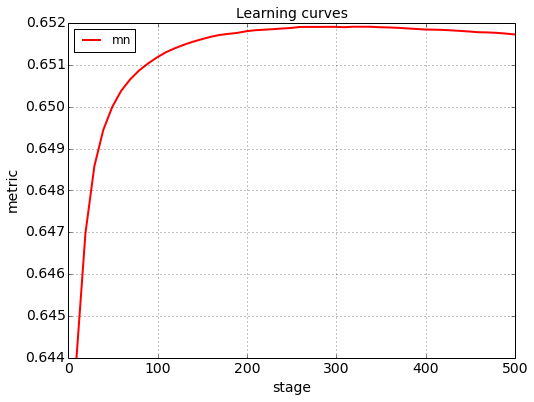

In [106]:
report = ClassificationReport({'mn': mn_folding_forest_top}, 
                              LabeledDataStorage(data_sw_passed_pair_selected, 
                                                 data_sw_passed_pair_selected.label.values,
                                                 data_sw_passed_pair_selected.N_sig_sw.values))
report.learning_curve(RocAuc())

--------

# Calibration

In [123]:
import utils
reload(utils)

<module 'utils' from 'utils.pyc'>

In [128]:
from utils import bootstrap_calibrate_prob, predict_by_estimator, calibrate_probs, compute_B_prob_using_part_prob
from utils import calculate_auc_with_and_without_untag_events, result_table

In [129]:
def run_calibration(tagging_efficiency, tagging_efficiency_delta, estimator,
                    datasets, name, logistic=True):
    # Calibration p(track same sign|B)
    
    data_calib, track_probs = predict_by_estimator(estimator, datasets)
    track_probs_calib = calibrate_probs(data_calib.label.values, data_calib.N_sig_sw.values, track_probs, 
                                        logistic=logistic)
    
    hist(track_probs[data_calib.label.values == 0], bins=60, normed=True, alpha=0.3, label='ss')
    hist(track_probs[data_calib.label.values == 1], bins=60, normed=True, alpha=0.3, label='os')
    legend(), title('track probs'), show()
    hist(track_probs_calib[data_calib.label.values == 0], bins=60, normed=True, alpha=0.3, label='ss')
    hist(track_probs_calib[data_calib.label.values == 1], bins=60, normed=True, alpha=0.3, label='os')
    legend(), title('track probs calibrated'), show()
    
    all_events = get_events_statistics(data_calib)['Events']
    assert all_events == get_events_statistics(data)['Events']
    
    # Compute p(B+)
    Bsign, Bweight, Bprob, Bevent = compute_B_prob_using_part_prob(data_calib, track_probs_calib)
    
    hist(Bprob[numpy.array(Bsign) == 1], bins=60, normed=True, alpha=0.3, label='$B^+$')
    hist(Bprob[numpy.array(Bsign) == -1], bins=60, normed=True, alpha=0.3, label='$B^-$')
    legend(), title('B probs'), show()
    assert all_events == len(Bprob), '{}, {}'.format(all_events, Bprob)
    
    # Compute p(B+) calibrated
    D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob)
    print 'mean AUC after calibration:', numpy.mean(aucs), numpy.var(aucs)
    auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob, Bweight)
    print 'AUC for tagged:', auc, 'AUC with untag:', auc_full
    return result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, name)

In [130]:
models = []

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


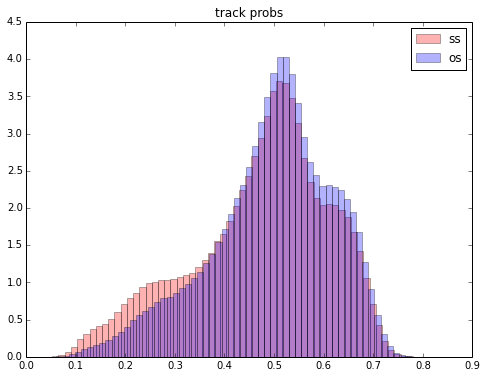

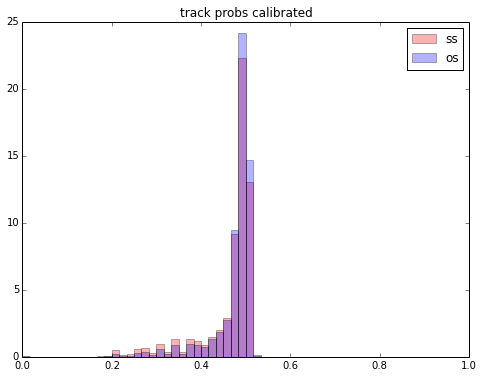

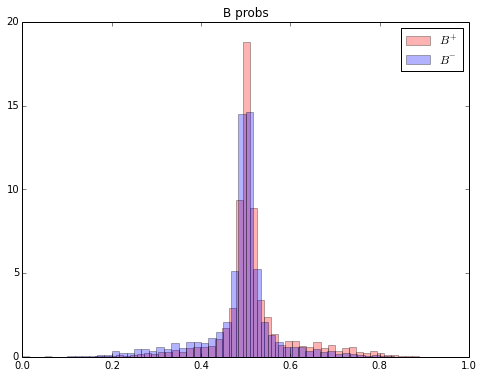

mean AUC after calibration: 0.589015130819 6.01222683061e-07
AUC for tagged: 0.588885684363 AUC with untag: 0.563548717292


In [131]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, mn_folding_forest_top, 
                              [data_sw_passed_pair_selected, data_sw_passed_pair_not_selected, data_sw_not_passed], 
                              'rt-top-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


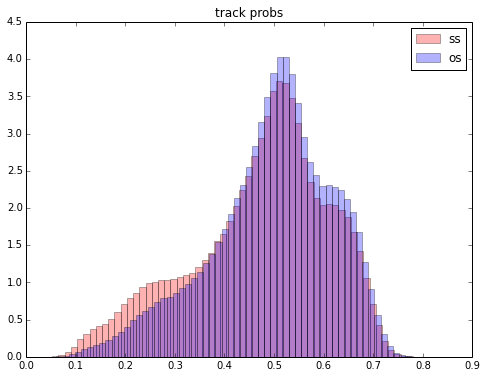

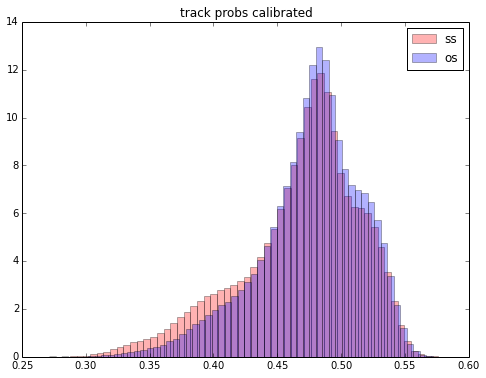

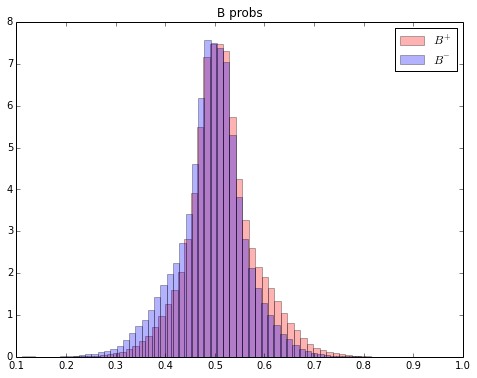

mean AUC after calibration: 0.587356041668 6.05356582315e-07
AUC for tagged: 0.587036452685 AUC with untag: 0.562754221215


In [133]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta,  mn_folding_forest_top, 
                              [data_sw_passed_pair_selected, data_sw_passed_pair_not_selected, data_sw_not_passed], 
                              'rf-top-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


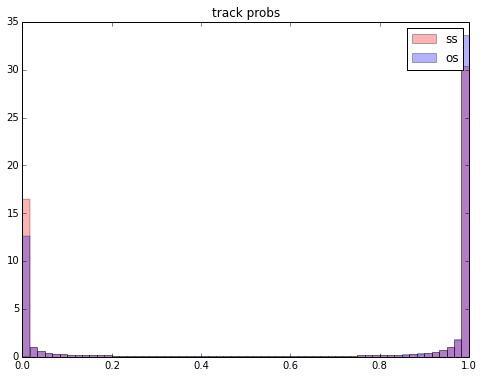

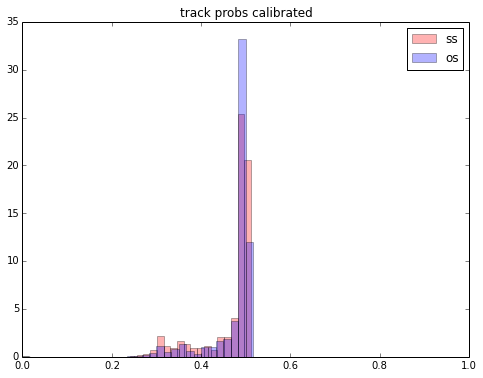

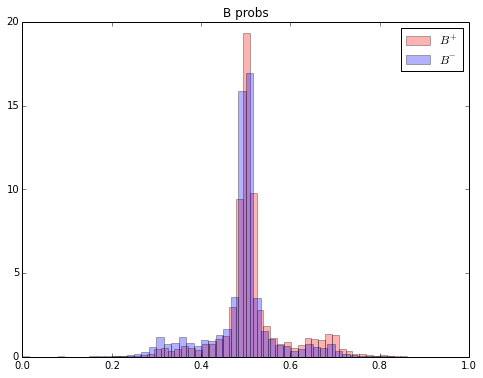

mean AUC after calibration: 0.587248161532 6.41192738888e-07
AUC for tagged: 0.587399111078 AUC with untag: 0.562409849323


In [134]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, mn_folding_forest, 
                              [data_sw_passed_rf_selected, data_sw_passed_rf_not_selected, data_sw_not_passed], 
                              'rf-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


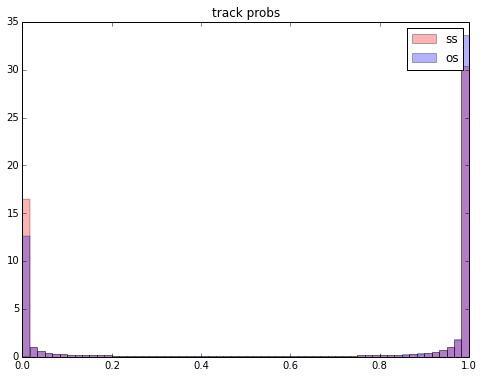

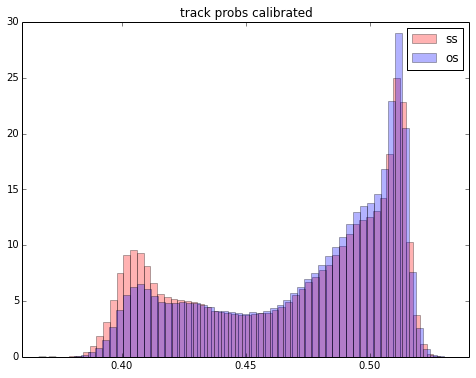

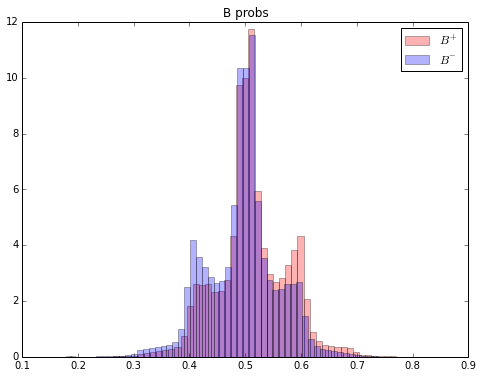

mean AUC after calibration: 0.58408698896 6.29982931189e-07
AUC for tagged: 0.584164323746 AUC with untag: 0.56077046204


In [135]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, mn_folding_forest, 
                              [data_sw_passed_rf_selected, data_sw_passed_rf_not_selected, data_sw_not_passed], 
                              'rf-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


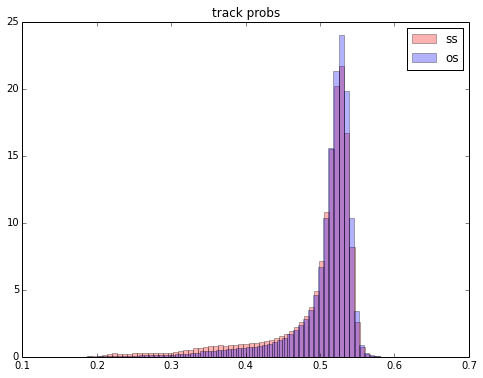

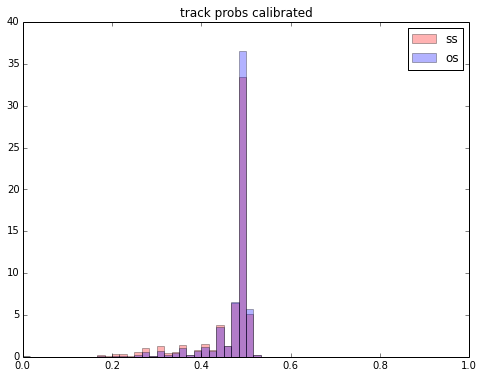

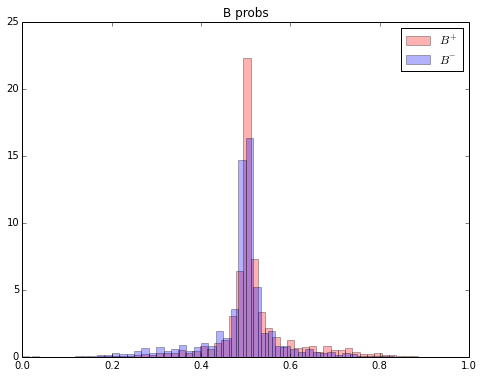

mean AUC after calibration: 0.58813118842 5.32483832028e-07
AUC for tagged: 0.588189874386 AUC with untag: 0.563024858855


In [136]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                              [data_sw_passed, data_sw_not_passed], 'tt-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


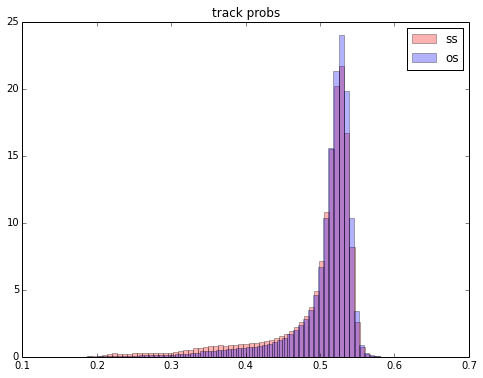

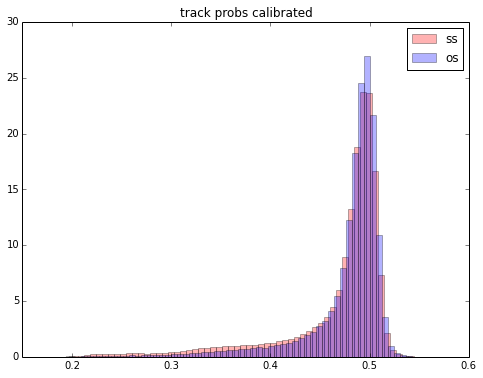

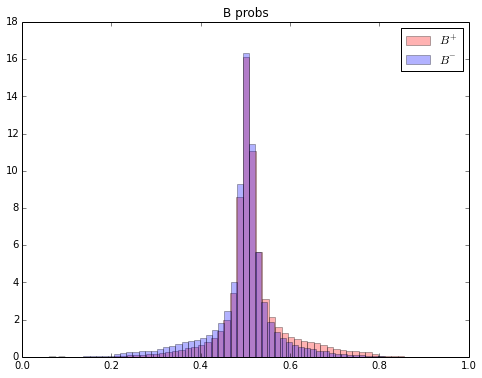

mean AUC after calibration: 0.58796451972 4.64329578919e-07
AUC for tagged: 0.588258304077 AUC with untag: 0.563024646106


In [137]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                              [data_sw_passed, data_sw_not_passed], 'tt-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


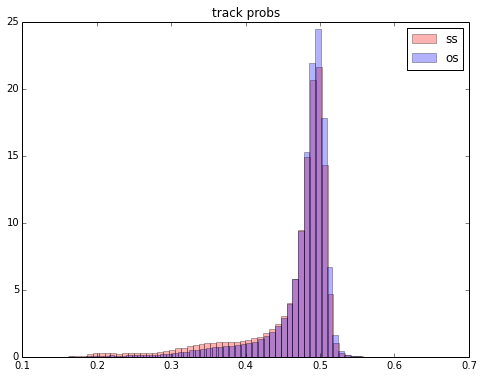

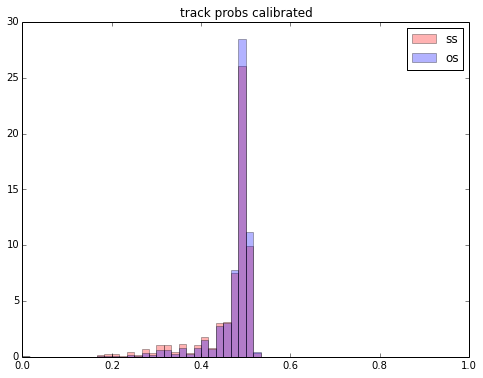

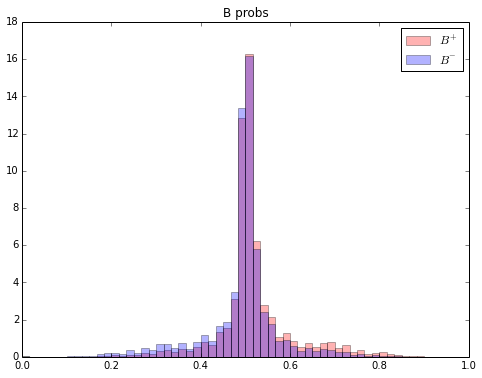

mean AUC after calibration: 0.588239080468 6.23828749983e-07
AUC for tagged: 0.588287147589 AUC with untag: 0.563222343886


In [138]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, mn_folding, 
                              [data_sw_passed, data_sw_not_passed], 'mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


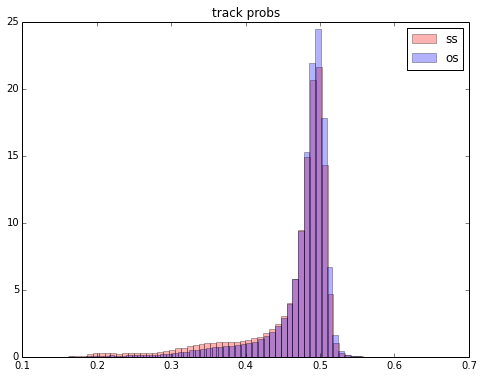

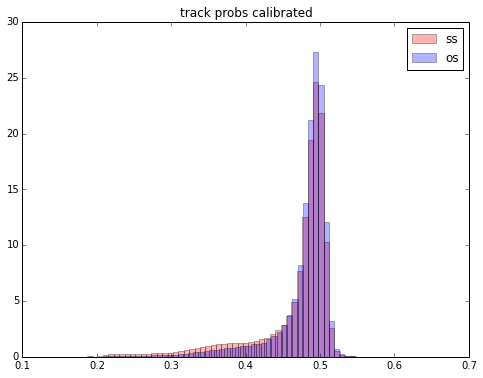

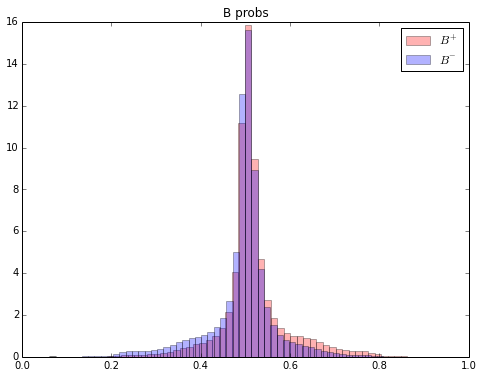

mean AUC after calibration: 0.588182598736 6.02510362579e-07
AUC for tagged: 0.588305894009 AUC with untag: 0.563336967511


In [139]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, mn_folding, 
                              [data_sw_passed, data_sw_not_passed], 'mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


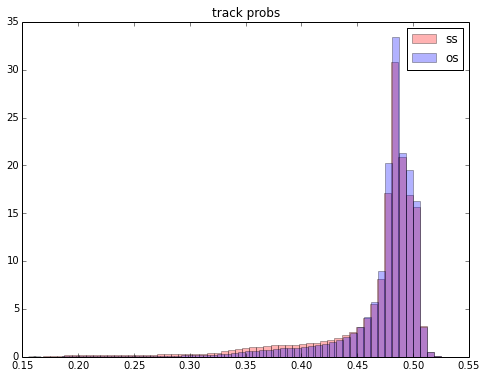

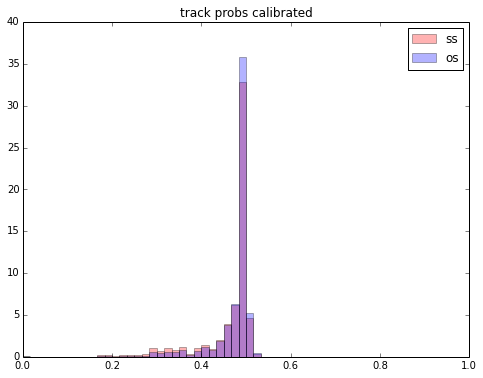

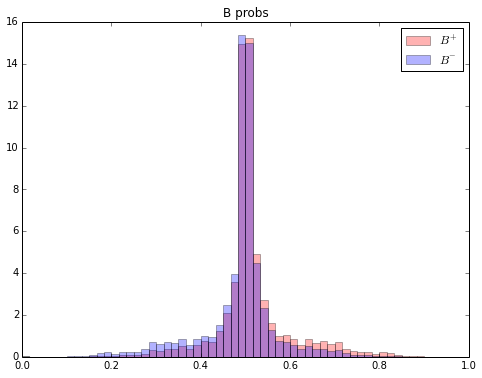

mean AUC after calibration: 0.58738987359 7.66961723591e-07
AUC for tagged: 0.587425275858 AUC with untag: 0.56240842568


In [ ]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, est_choose_RT, 
                              [data_sw_passed, data_sw_not_passed], 'rf-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


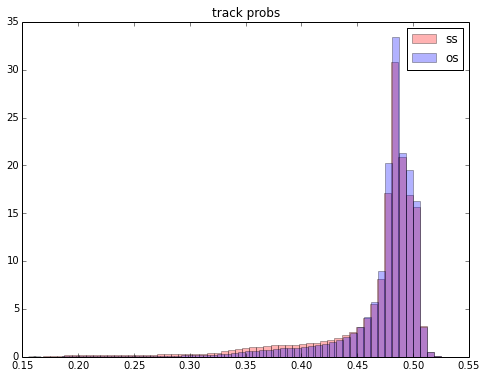

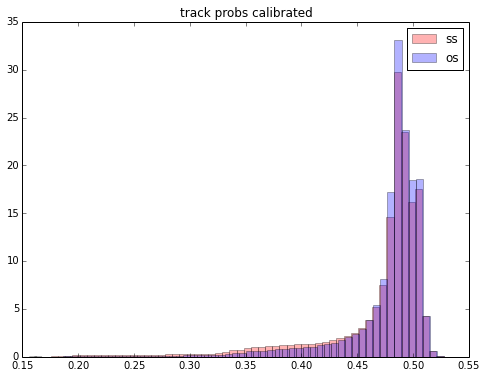

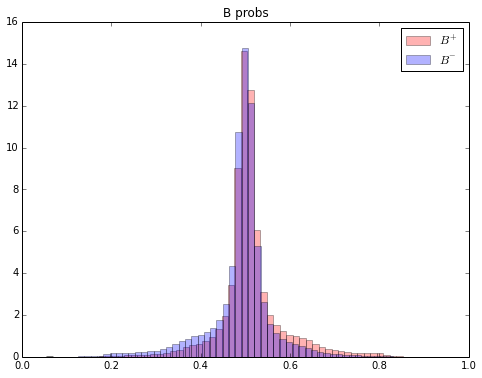

In [ ]:
models.append(run_calibration(tagging_efficiency, tagging_efficiency_delta, est_choose_RT, 
                              [data_sw_passed, data_sw_not_passed], 'rf-log', logistic=True))

In [143]:
pandas.set_option('display.precision', 8)
result = pandas.concat(models)
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
name,,,,,,,,
rt-top-mn-iso,66.9482289,0.0949323,0.0290847,0.0005538,1.9471683,0.0371787,56.3548717,0
rf-top-mn-log,66.9482289,0.0949323,0.0289234,0.0004199,1.9363736,0.0282429,56.2754221,0
rf-mn-iso,66.9482289,0.0949323,0.0273756,0.0006268,1.8327457,0.0420464,56.2409849,0
rf-mn-log,66.9482289,0.0949323,0.0254405,0.0003206,1.7031945,0.0215992,56.0770462,0
tt-iso,66.9482289,0.0949323,0.0293055,0.0005450,1.9619535,0.0365953,56.3024859,0
tt-log,66.9482289,0.0949323,0.0326870,0.0004336,2.1883350,0.0291957,56.3024646,0
mn-iso,66.9482289,0.0949323,0.0298613,0.0004638,1.9991579,0.0311768,56.3222344,0
mn-log,66.9482289,0.0949323,0.0326166,0.0004278,2.1836233,0.0288104,56.3336968,0
rf-iso,66.9482289,0.0949323,0.0289810,0.0004969,1.9402269,0.0333822,56.2408426,0


--------------------------

## The best tracking

KFold prediction using folds column
KFold prediction using folds column


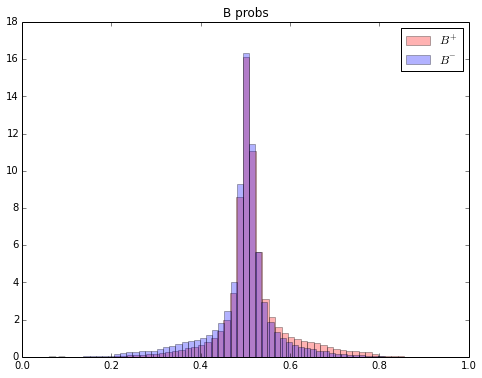

AUC for tagged: 0.588258304077 AUC with untag: 0.563024646106


In [145]:
data_prepared_predicted, track_prepared_probs = predict_by_estimator(tt_folding, [data_sw_passed, data_sw_not_passed])

track_prepared_probs_calibrated = calibrate_probs(data_prepared_predicted.label.values,
                                                  data_prepared_predicted.N_sig_sw.values, track_prepared_probs, 
                                                  logistic=True)
    
# Compute p(B+)
Bsign_prepared, Bweight_prepared, Bprob_prepared, Bevent_prepared = compute_B_prob_using_part_prob(
    data_prepared_predicted, track_prepared_probs_calibrated)
    
hist(Bprob_prepared[Bsign_prepared == 1], bins=60, normed=True, alpha=0.3, label='$B^+$')
hist(Bprob_prepared[Bsign_prepared == -1], bins=60, normed=True, alpha=0.3, label='$B^-$')
legend(), title('B probs'), show()
auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign_prepared, Bprob_prepared, Bweight_prepared)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

In [147]:
Bdata_prepared = pandas.DataFrame({'event_id': Bevent_prepared, 
                                 'weight': Bweight_prepared, 
                                 'track_prob': Bprob_prepared / (1 - Bprob_prepared), 
                                 'Bsign': Bsign_prepared})

(0, 1)

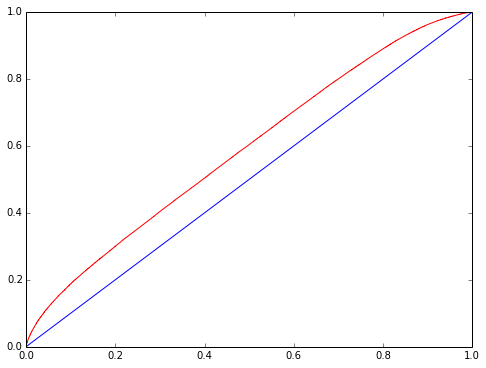

In [149]:
fpr, tpr, _ = roc_curve(Bsign_prepared, Bprob_prepared, sample_weight=Bweight_prepared)
plot(fpr, tpr)
plot([0, 1], [0, 1])
ylim(0, 1)

In [150]:
Bdata_prepared.to_csv('models/Bdata_track.csv', header=True, index=False)